In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from math import pi as pi
import re

In [20]:
def integerisation(data):
    return np.array(data).astype(int)

def get_file(filename, batch=False):
    line=[]
    length=2105601
    with open(filename, "r") as file:
        for i in range(0,length):
            line.append(file.readline())
    return line  

def intfromstr(string1):
    return int(re.search(r'\d+', string1).group())

In [23]:
class SansData:
    def __init__(self, filename, title=None, textsize=12):
        # Initialization with detector settings and file loading
        self.filename = filename
        self.setup_detector_geometry()
        self.load_data(filename)
        self.process_data()
        self.velocity_selector_speed = self.load_velocity_selector()
        self.lam = self.calculate_lambda_from_velocity(self.velocity_selector_speed)  # Calculate lambda from velocity
        print(f"lamda: {self.lam}")

        # Define the ranges and beam stop information here
        self.x_ranges = [(400, 450), (450, 600)]
        self.y_ranges = [(200, 250), (250, 300)]
        self.beam_stop_range_x = (430, 480)
        self.beam_stop_range_y = (230, 260)
        
        # Initialize the attributes with default values
        self.delta_omega = 1.0  # Example value
        self.d_sample = 0.05     # Example value
        self.i0_lambda = 1.0    # Example value
        self.transmission_lambda = 1.0  # Example value
        # Define the distances based on the provided geometry (in mm)
        self.distances = {
            'D_to_DS': 1320 + 0,        # Distance from diaphragm to sample, + PosFzz
            'DS_to_S': 1320,     # Distance from DS to Sample
            'DS_to_KB3': 2802,    # Distance from Sample to KB3
            'DS_to_KB2': 4793,  # Distance from KB3 to KB2
            'DS_to_KB1': 8798,  # Distance from KB2 to KB1
            'DS_to_PB1': 11606  # Distance from KB1 to P01
        }
        # Define the apertures sizes (in mm) for each diaphragm
        self.apertures = {
            'D': 10,       # Aperture size for diaphragm D
            'DS': 10,      # Aperture size for DS
            'S': 10,       # Aperture size for Sample
            'KB3': 10,     # Aperture size for KB3
            'KB2': 10,     # Aperture size for KB2
            'KB1': 10,     # Aperture size for KB1
            'PB1': 10      # Aperture size for P01
        }

    def setup_detector_geometry(self):
        # Detector geometry setup
        self.ymin = 50
        self.ymax = 1024 - 50
        self.y = (1024-100)
        self.pixely = 0.5 / self.y #ypixel size [m]
        self.xmin = 275 
        self.xmax = 750
        self.x = 1024 - 275 - 274 #number of x pixels #changed from 225 to 275
        self.pixelx = 0.5 / self.x #xpixel size [m]
#        self.lam = 5.8# *10**(-10) #e-10 # Wavelength in meter
        self.d = (self.load_distance() +1320)/1000 # [m] 1320 is the offset
        self.n_sectors = 6
        #Sample to detector distance is FZZ +1320
        print(f"Pixel size X: {self.pixelx} m, Pixel size Y: {self.pixely} m")
        
    def load_distance(self):
        with open(self.filename, 'r') as file:
            lines = file.readlines()
            if len(lines) >= 7:
                seventh_line = lines[6].strip()
                print(f"seventh line: {seventh_line}")
                # Assuming the distance is always 2.520 as per your requirement
                distance = float(seventh_line.split('=')[1])
                print(f"new distance1: {distance}")
                return distance
    
    def load_velocity_selector(self):
        with open(self.filename, 'r') as file:
            lines = file.readlines()
            if len(lines) >= 18:
                eighteenth_line = lines[17].strip()
                print(f"eighteenth line: {eighteenth_line}")
                velocity_selector_speed = int(eighteenth_line.split('=')[1])
                print(f"velocity selector speed: {velocity_selector_speed}")
                return velocity_selector_speed
    def calculate_lambda_from_velocity(self, velocity):
        rpm = np.array([25450, 23100, 21200, 14150, 12700, 11550, 10600, 9750, 9100]) # from the test data
        wavelengths = np.array([5.0, 5.5, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])
        sorted_indices = np.argsort(rpm)
        sorted_wavelengths = wavelengths[sorted_indices]
        sorted_rpm = rpm[sorted_indices]
        
        # Linear fit function
        def fit_func(x, a, b):
            return a / x + b
        
        # Perform linear fit
        popt, _ = curve_fit(fit_func, sorted_rpm, sorted_wavelengths)
        interpolated_lambda = fit_func(velocity, *popt)
        print(f"Interpolated lambda: {interpolated_lambda} Å for velocity {velocity} RPM")
        return interpolated_lambda

    def load_data(self, filename):
        # Assuming get_file, integerisation, and intfromstr are defined
        data = get_file(filename)
        offset = 29
        self.filename = filename
        self.sample = data[1]
        self.runtime = intfromstr(data[46])
        self.tdat0 = integerisation(data[248 + offset:1272 + offset])
        self.tdat1 = integerisation(data[1273 + offset:2297 + offset])
        self.tdat2 = integerisation(data[2298 + offset:3322 + offset])
        self.tdat3 = integerisation(data[3323 + offset:4347 + offset])
        self.cdat0 = integerisation(data[4348 + offset:5372 + offset])
        self.cdat1 = integerisation(data[5373 + offset:6397 + offset])
        cdat2 = integerisation(data[6398 + offset:1054974 + offset])
        cdat3 = integerisation(data[1054975 + offset:2103551 + offset])
        self.cdat2_2d = np.reshape(cdat2, (1024, 1024))
        self.cdat3_2d = np.reshape(cdat3, (1024, 1024))
        self.twod= np.transpose(self.cdat2_2d[self.xmin:self.xmax, self.ymin:self.ymax])
        # Center the twod data
        # Find the center using FWHM method
        # self.find_center_by_fwhm()
        # Print the arrays and their shapes
        print(f"self.cdat2_2d shape: {self.cdat2_2d.shape}")
#        print(f"self.cdat2_2d: {self.cdat2_2d}")
        print(f"self.twod shape: {self.twod.shape}")
#        print(f"self.twod: {self.twod}")

    def process_data(self):
        self.i_s = np.sum(self.twod, axis=0) 
        # Any additional data processing
        pass
    
    def plot_integrated_intensity(self, data=None, axis=0, title='Integrated Intensity', filename=None):
        """
        Plot combined integrated intensities along both X and Y axes with both pixel and distance representations.
        """
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # Arrange plots in 2 rows, 1 column

        # Plot integrated intensity along X-axis (summed over Y) in pixels
        data = self.twod
        integrated_intensity_x = np.sum(data, axis=0)
        integrated_intensity_y = np.sum(data, axis=1)

        ax = axes[0]
        x_values_pixels = np.arange(integrated_intensity_x.size)
        ax.plot(x_values_pixels, integrated_intensity_x)
        ax.axvline(self.center_x, color='red', linestyle='--', linewidth=1, label='Center')
        ax.axvline(self.center_x - self.fwhm_x / 2, color='blue', linestyle='--', linewidth=1, label='FWHM')
        ax.axvline(self.center_x + self.fwhm_x / 2, color='blue', linestyle='--', linewidth=1)
#        ax.set_xlim(200, 300)
        ax.set_title('Integrated Intensity over X-axis (Summed over Y)')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Integrated Intensity')
        ax.legend()

        # Plot integrated intensity along Y-axis (summed over X) in pixels
        ax = axes[1]
        y_values_pixels = np.arange(integrated_intensity_y.size)
        ax.plot(y_values_pixels, integrated_intensity_y)
        ax.axvline(self.center_y, color='red', linestyle='--', linewidth=1, label='Center')
        ax.axvline(self.center_y - self.fwhm_y / 2, color='blue', linestyle='--', linewidth=1, label='FWHM')
        ax.axvline(self.center_y + self.fwhm_y / 2, color='blue', linestyle='--', linewidth=1)
        ax.set_xlim(300, 600)
        ax.set_title('Integrated Intensity over Y-axis (Summed over X)')
        ax.set_xlabel('Y (pixels)')
        ax.set_ylabel('Integrated Intensity')
        ax.legend()

        plt.tight_layout()
        plt.show()
        
        

    
    def convert_iq(self):
        """ 
        Convert intensity data to scattering intensity I(q) and apply calibration crrections
        """
        #Calculate distances and positions
        self.val_bin, self.bin_indices_matrix, self.distances,self.x_positions, self.y_positions, self.angles = det_distances(self.x, self.y, self.pixelx, self.pixely, self.center_x, self.center_y,100)

        # Maximum distance from center
        max_distance = np.max(self.distances)
        print(f"Maximum distance from center: {max_distance} meters")
#        print(f"angles 1: {self.angles}")
        print(f"angles 1 shape: {self.angles.shape}")
        
        self.iq = radial(self.twod, self.val_bin, self.bin_indices_matrix, self.angles, self.n_sectors)  # Calculate the radial average intensity I(q)
        print(f"iq length: {len(self.iq)}")
#        for i, element in enumerate(self.iq):
#            print(f"iq element {i} length: {len(element)}")
        #print(f"iq: {self.iq}")
        # Find the minimum length among the elements
        min_length = min(len(element) for element in self.iq)
        print(f"Minimum length: {min_length}")

        # Trim each element to the minimum length
        self.iq = [element[:min_length] for element in self.iq]
#        print(f"Trimmed iq: {[len(element) for element in self.iq]}")

        # Convert iq to numpy array for further processing
        self.iq = np.array(self.iq)
        print(f"iq shape after trimming: {self.iq.shape}")

        # Flatten distances for q-value calculation
        flat_distances = self.distances.flatten()
        pixel_q_values = convertoq(flat_distances, self.lam, self.d) #, y=0 as these are already the distances
        print(f"All q values shape: {pixel_q_values.shape}")

        # Reshape pixel_q_values to match the detector matrix
        pixel_q_values_reshaped = pixel_q_values.reshape(self.distances.shape)
        print(f"Reshaped q values shape: {pixel_q_values_reshaped.shape}")

        # Radially average the q values
        self.q = radial(pixel_q_values_reshaped, self.val_bin, self.bin_indices_matrix, self.angles, self.n_sectors)
        print(f"q length: {len(self.q)}")
#        for i, element in enumerate(self.q):
#            print(f"q element {i} length: {len(element)}")

        # Find the minimum length among the elements in q
        min_length_q = min(len(element) for element in self.q)
        print(f"Minimum q length: {min_length_q}")

        # Trim each element in q to the minimum length
        self.q = [element[:min_length_q] for element in self.q]
        print(f"Trimmed q: {[len(element) for element in self.q]}")
        
        self.q = np.array(self.q) # Ensure self.q is a numpy array
        #print(f"Radially averaged q: {self.q}")
        print(f"shape q: {np.shape(self.q)}")
        # Check if self.q is correctly formatted

        
        # Calculate the correction factors for each pixel's q value
        pixel_correction_factors = solid_angle_correction(pixel_q_values_reshaped, self.lam, self.d)
        print(f"Pixel-wise correction factors shape: {pixel_correction_factors.shape}")

        # Radially average the correction factors
        radial_correction_factors = radial(pixel_correction_factors, self.val_bin, self.bin_indices_matrix, self.angles, self.n_sectors)
        radial_correction_factors = np.array(radial_correction_factors)
#        print(f"Radially averaged correction factors: {radial_correction_factors}")
        print(f"radial_correction_factors length: {len(radial_correction_factors)}")
#        for i, element in enumerate(radial_correction_factors):
#            print(f"radial_correction_factors element {i} length: {len(element)}")
        # Ensure self.q and radial_correction_factors are 1D numpy arrays
        # Find the minimum length among the elements in radial_correction_factors
        min_length_rcf = min(len(element) for element in radial_correction_factors)
        print(f"Minimum radial_correction_factors length: {min_length_rcf}")

        # Trim each element in radial_correction_factors to the minimum length
        radial_correction_factors = [element[:min_length_rcf] for element in radial_correction_factors]
        print(f"Trimmed radial_correction_factors: {[len(element) for element in radial_correction_factors]}")

        # Convert radial_correction_factors to numpy array for further processing
        radial_correction_factors = np.array(radial_correction_factors)
        print(f"shape radial_correction_factors after trimming: {radial_correction_factors.shape}")

        # Compute corrected intensities
        self.iq_corrected = np.array([iq / radial_correction_factors[i] for i, iq in enumerate(self.iq)])
        print(f"iq_corrected shape: {self.iq_corrected.shape}")
       
        # Calculate maximum averaged radial distance
        max_averaged_radial_distance = self.calculate_max_averaged_radial_distance(self.distances, self.bin_indices_matrix)
        print(f"Maximum averaged radial distance: {max_averaged_radial_distance} meters")
        

    def calculate_max_averaged_radial_distance(self, distances, bin_indices_matrix):
        """
        Calculate the maximum averaged radial distance.
        """
        unique_bins = np.unique(bin_indices_matrix)
        max_averaged_distance = 0
        for bin_index in unique_bins:
            indices = np.where(bin_indices_matrix == bin_index)
            average_distance = np.mean(distances[indices])
            if average_distance > max_averaged_distance: 
                max_averaged_distance = average_distance # Update the maximum averaged distance if the current average is greater
        return max_averaged_distance
            
    def plot_2d(self, writepdf=False, filename='2dplot.pdf'):
        """
        Plot the 2D intensity data.
        """
        norm = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))
        plt.figure()
        plt.pcolormesh(self.twod, norm=norm, shading='gouraud')
        plt.colorbar(label='Intensity')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.show()
        plt.figure()
        plt.pcolormesh(self.twod, norm=norm, shading='gouraud')
        plt.colorbar(label='Intensity')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.xlim(200, 300)
        plt.ylim(350, 600)
        if writepdf:
            plt.savefig(filename)
        plt.show()
        
    def calculate_absolute_intensity(self):
        """
        Calculate the absolute intensity (Macroscopic scattering cross section) of the scattering data.
        """
        print(f"delta_omega: {self.delta_omega}, i0_lambda: {self.i0_lambda}, transmission_lambda: {self.transmission_lambda}, d_sample: {self.d_sample}")
        self.absolute_intensity = np.array(self.iq_corrected) / (self.delta_omega * self.i0_lambda * self.transmission_lambda * self.d_sample)
    #    print(f"absolute_intensity: {self.absolute_intensity}")
        print(f"absolute_intensity shape: {self.absolute_intensity.shape}")
        
    def radial_average_absolute_intensity(self):
        """
        Calculate the radial average of the absolute intensity for each sector.
        """
        num_sectors = self.n_sectors
        min_length = self.absolute_intensity.shape[1]

        # Initialize arrays to hold the radial average and count for each sector
        radial_average = np.zeros((num_sectors, min_length))
        count = np.zeros((num_sectors, min_length))

        # Calculate the radial average for each sector
        for sector in range(num_sectors):
            for i in range(min_length):
                radial_average[sector, i] += self.absolute_intensity[sector, i]
                count[sector, i] += 1

        # Compute the average, avoiding division by zero
        self.absolute_intensity_avg = np.divide(radial_average, count, out=np.zeros_like(radial_average), where=count != 0)
        # Check the shapes
        print(f"Shape of self.q: {self.q.shape}")
        print(f"Shape of absolute_intensity_avg: {self.absolute_intensity_avg.shape}")
 
        
    def calculate_divergence_angle(self, aperture_size, distance):
        if distance == 0:
            return 0
        return np.arctan(aperture_size / (2 * distance))
    
    def calculate_beam_divergence(self):
        divergence_angles = {}
        previous_aperture_size = self.apertures['D']
        for key, distance in self.distances.items():
            divergence_angles[key] = self.calculate_divergence_angle(previous_aperture_size, distance)
        return divergence_angles 


    def plot_scattering_cross_section(self,combined_sectors):
        if not hasattr(self, 'absolute_intensity_avg') or not hasattr(self, 'q'):
            raise ValueError("Absolute intensity or q-values are not calculated.")

        # Check the shapes to ensure they are compatible
        if self.q.shape != self.absolute_intensity_avg.shape:
            raise ValueError(f"Shape mismatch: q has shape {self.q.shape}, while absolute_intensity_avg has shape {self.absolute_intensity_avg.shape}")

        num_sectors = self.q.shape[0]
        plt.figure(figsize=(10, 6))

        # Plot each sector's data
        for sector_range in combined_sectors:
            for sector in range(sector_range[0], sector_range[1] + 1):
                if sector < num_sectors:
                    plt.plot(self.q[sector], self.absolute_intensity_avg[sector], label=f'Sector {sector + 1}')

        plt.title('Scattering Cross Section vs. Q-Value')
        plt.xlabel('Q-Value (1/Å)')
        plt.ylabel('Scattering Cross Section')
        plt.yscale('log')
        plt.xscale('log')
        plt.grid(True)
        plt.legend()
        plt.show()
    

    def plot_qx_qy(self, combined_sectors):
        """
        Plot Qx vs Qy maps and scatter plots with logarithmic intensity scale.
        """
        # Use the det_distances function to calculate the positions and distances
        self.val_bin, self.bin_indices_matrix, self.distances, self.x_positions, self.y_positions, self.angles = det_distances(
            self.x, self.y, self.pixelx, self.pixely, self.center_x, self.center_y)

        # Calculate qx and qy values using the convertoq function
        qx = convertoq(self.x_positions, self.lam, self.d)
        qy = convertoq(self.y_positions, self.lam, self.d)

        # Debug statements
        print(f"x_positions shape: {self.x_positions.shape}")
        print(f"y_positions shape: {self.y_positions.shape}")
        print(f"qx shape: {qx.shape}")
        print(f"qy shape: {qy.shape}")   

        extent_x = (-(self.center_x * self.pixelx), (self.x - self.center_x) * self.pixelx)
        extent_y = (-(self.center_y * self.pixely), (self.y - self.center_y) * self.pixely)

        plt.figure(figsize=(20, 8))

        plt.figure(figsize=(10, 8))
        norm1 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))
        scatter = plt.scatter(qx, qy, c=self.twod, cmap='viridis', s=1, norm=norm1)
        plt.colorbar(scatter, label='Intensity')
        plt.title('Qx vs Qy reshaped')
        plt.xlabel('Qx (1/Å)')
        plt.ylabel('Qy (1/Å)')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 10))
        norm1 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))

        # Plotting the centered 2D data using imshow
        im = plt.imshow(self.twod, cmap='viridis', norm=norm1, origin='lower')
        plt.scatter(np.array([self.center_x]), np.array([self.center_y]), color='red', s=100, marker='x', label='Center Point')

        # Plot the cross
        plt.axvline(x=self.center_x, color='red', linestyle='-', linewidth=1)
        plt.axhline(y=self.center_y, color='red', linestyle='-', linewidth=1)

        plt.title('Centered 2D Data with Extent in Pixels')
        plt.xlabel('X (pixels)')
        plt.ylabel('Y (pixels)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Plot Qx vs Qy for combined sectors
        plt.figure(figsize=(10, 8))
        norm2 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))

        # Filter qx and qy based on combined sectors
        for sector_range in combined_sectors:
            for sector in range(sector_range[0], sector_range[1] + 1):
                sector_mask = (self.angles >= (sector - 1) * (360 / self.n_sectors)) & (self.angles < sector * (360 / self.n_sectors))
                plt.scatter(qx[sector_mask], qy[sector_mask], c=self.twod[sector_mask], cmap='viridis', s=1, norm=norm2)

        plt.colorbar(label='Intensity')
        plt.title('Qx vs Qy for Combined Sectors')
        plt.xlabel('Qx (1/Å)')
        plt.ylabel('Qy (1/Å)')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(8, 8))  # Adjust figsize to make the plot square
        norm1 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))

        # Calculate extent in meters
        extent = [-(self.center_x * self.pixelx), (self.x - self.center_x) * self.pixelx, 
                  -(self.center_y * self.pixely), (self.y - self.center_y) * self.pixely]
        
        # Calculate center position in meters
        center_x_m = (self.center_x - self.x / 2) * self.pixelx
        center_y_m = (self.center_y - self.y / 2) * self.pixely
        
        # Plotting the centered 2D data using imshow with extent in meters
        im = plt.imshow(self.twod, cmap='viridis', norm=norm1, origin='lower', extent=extent)
        plt.scatter([center_x_m], [center_y_m], color='red', s=100, marker='x', label='Center Point')

        # Plot the cross in meters
        plt.axvline(x=center_x_m, color='red', linestyle='-', linewidth=1)
        plt.axhline(y=center_y_m, color='red', linestyle='-', linewidth=1)

        plt.title('Centered 2D Data with Extent in Meters')
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
        plt.show()

seventh line: FZZ=4.99472
new distance1: 4.99472
Pixel size X: 0.0010526315789473684 m, Pixel size Y: 0.0005411255411255411 m
self.cdat2_2d shape: (1024, 1024)
self.twod shape: (924, 475)
eighteenth line: SpeedVS=21200
velocity selector speed: 21200
Interpolated lambda: 5.997948802103647 Å for velocity 21200 RPM
lamda: 5.997948802103647


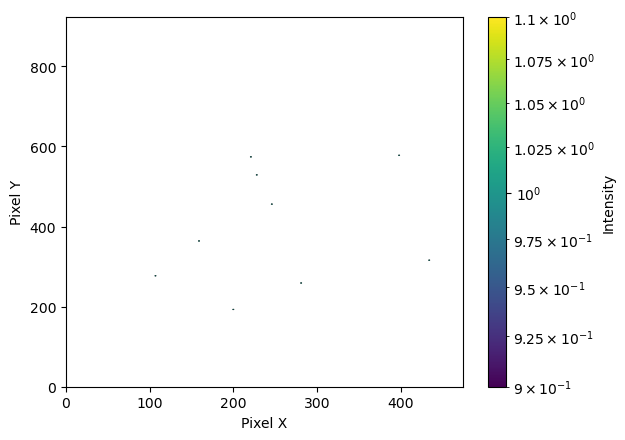

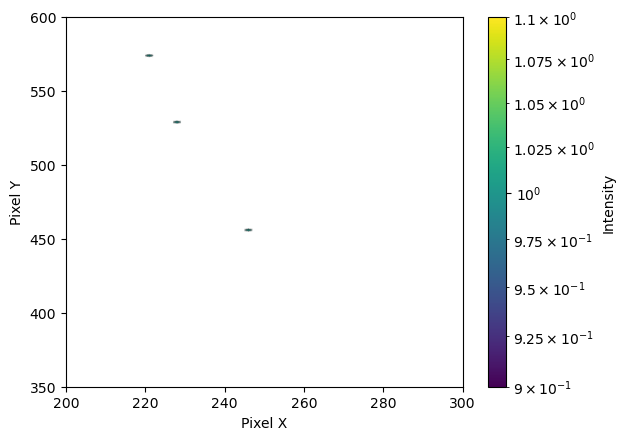

In [26]:
glassyC_sample = SansData('data/s08_07_24_backG_1202s_reactor_on.mpa')
glassyC_sample.plot_2d()